# Homework-  26.11.2018:
## State of the Art Neural Network Architectures

The purpose of this homework is to implement and evaluate the sota architectures presented in the lecture.
However, you are encouraged to try your own layer module ideas.
Feel free to consult the [Keras source code](https://github.com/keras-team/keras-applications):




1. Based on the CNN modules presented in the lecture e.g. VGG16, Inception, ResNet, Xception, DenseNet, come up with your own CNN module and write a small text discussing your idea and motivations behind the module.

2. Evaluate all your module using the Keras CIFAR10 dataset splits (The model with best test accuracy will present their solution to the class).

In [18]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [19]:
import numpy as np
print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_test))
print(np.shape(y_test))
#print(x_train[0,:,:,:])#,RGB = 3
#print(y_train)

x_train[0,0,0,0]

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


59

## Idea ##

Use hirarchy to learn. E.g. first layer learns edges, next one learns collections of edges (shapes), next layer will be trained to recognize collections of shapes (tails, face), until we get can recognise high level features (truck, ships, dog) towards the end of the NN.

First, we try a regualar AlexNet Architecture.

In [11]:
#Hyperparameters
img_shape = (32,32,3)
classes_num = 10

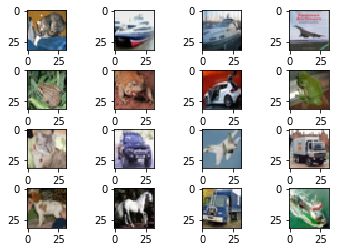

In [21]:
#Visualize data
import matplotlib.pyplot as plt
from PIL import Image

def show_Images(images):
    plt.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            plt.subplot2grid((4,4),(i,j))
            plt.imshow(Image.fromarray(images[k]))
            k = k+1
    plt.subplots_adjust(hspace = 0.5)
    plt.show()

show_Images(x_test[:16])

In [22]:
#Transform data to fit softmax
from tensorflow.keras import utils
y_train_categorical = utils.to_categorical(y_train, classes_num)
y_test_categorical = utils.to_categorical(y_test, classes_num)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [23]:
#MODEL: AlexNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

alexnet = Sequential()

# Layer 1
# 96 filter mit 11x11 convolution too big for 32x32 img?
alexnet.add(Conv2D(96, (11, 11), input_shape=img_shape, padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2
alexnet.add(Conv2D(256, (5, 5), padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3
alexnet.add(Conv2D(384, (3, 3), padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4
alexnet.add(Conv2D(384, (3, 3), padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))

# Layer 5
alexnet.add(Conv2D(256, (3, 3), padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(MaxPooling2D(pool_size=(2, 2)))

alexnet.add(Flatten())

# Layer 6 - fully connected layer
alexnet.add(Dense(4096))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(Dropout(0.5))

# Layer 7
alexnet.add(Dense(4096))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(Dropout(0.5))

# Layer 8
alexnet.add(Dense(classes_num))
alexnet.add(BatchNormalization())
alexnet.add(Activation('softmax'))

#alexnet.summary() #~25.000.000 parameters to learn

In [24]:
#Compile 
alexnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Train
alexnet.fit(x_train, y_train_categorical, validation_data=(x_test,y_test_categorical), batch_size=64, epochs=5, verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 62s 1ms/step - loss: 1.4157 - acc: 0.5049 - val_loss: 1.4982 - val_acc: 0.4904
Epoch 2/5
50000/50000 [==============================] - 57s 1ms/step - loss: 1.0380 - acc: 0.6491 - val_loss: 1.2788 - val_acc: 0.5870
Epoch 3/5
50000/50000 [==============================] - 57s 1ms/step - loss: 0.8340 - acc: 0.7225 - val_loss: 1.1969 - val_acc: 0.6003
Epoch 4/5
50000/50000 [==============================] - 57s 1ms/step - loss: 0.6912 - acc: 0.7720 - val_loss: 1.1507 - val_acc: 0.6217
Epoch 5/5
50000/50000 [==============================] - 57s 1ms/step - loss: 0.5728 - acc: 0.8128 - val_loss: 0.9361 - val_acc: 0.6920


In [25]:
scores = alexnet.evaluate(x_test, y_test_categorical, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 2s 224us/step

Test result: 69.200 loss: 0.936


## Result interpretation ##

Traning ~25 million parameters on 50000 samples seems too much, lets try a smaller size.
Additionally, ELU activation will replace RELU activation (smoother loss surface and no "Dead ReLU").
Dropout has been added to prevent overfitting of the NN.
Also, regularizers have been added to prevent overfitting while maintaining accuracy at a high level.

In [12]:
#MODEL: Simpler CNN; cite: https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import regularizers
 
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=img_shape))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(classes_num, activation='softmax'))
 
#model.summary() #~300.000 parameters to learn
 

In [11]:
#Model overfitt after around 50 epochs. Only training accuracy increases further. -> early stopping (additionally saves time)
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=4,
                              verbose=0, mode='auto')]

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train, y_train_categorical, batch_size=64,epochs=128, verbose=1,\
          validation_data=(x_test,y_test_categorical), callbacks=callbacks)
 
    
#testing
scores = model.evaluate(x_test, y_test_categorical, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

Train on 50000 samples, validate on 10000 samples
Epoch 1/125
50000/50000 [==============================] - 19s 384us/step - loss: 0.4388 - acc: 0.9191 - val_loss: 0.7145 - val_acc: 0.8461
Epoch 2/125
50000/50000 [==============================] - 17s 350us/step - loss: 0.4287 - acc: 0.9241 - val_loss: 0.6858 - val_acc: 0.8610
Epoch 3/125
50000/50000 [==============================] - 18s 362us/step - loss: 0.4340 - acc: 0.9209 - val_loss: 0.6731 - val_acc: 0.8607
Epoch 4/125
50000/50000 [==============================] - 18s 362us/step - loss: 0.4295 - acc: 0.9216 - val_loss: 0.7014 - val_acc: 0.8522
Epoch 5/125
50000/50000 [==============================] - 18s 358us/step - loss: 0.4249 - acc: 0.9231 - val_loss: 0.7043 - val_acc: 0.8527
Epoch 6/125
50000/50000 [==============================] - 18s 357us/step - loss: 0.4316 - acc: 0.9212 - val_loss: 0.6847 - val_acc: 0.8543
Epoch 7/125
10000/10000 [==============================] - 1s 93us/step

Test result: 85.240 loss: 0.708


In [32]:
#Data augmentation and z-score didnt improve accuracy (dataset to small to make these changes meaningfull?)

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator( 
                 rotation_range=90,
                 width_shift_range=0.1, 
                 height_shift_range=0.1,
                 horizontal_flip=True)
datagen.fit(x_train)

#z-score (for similar ranged features, similar gradients)
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)
 

callbacks = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=4,
                              verbose=0, mode='auto')]

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train, y_train_categorical, batch_size=64,epochs=128, verbose=1,\
          validation_data=(x_test,y_test_categorical), callbacks=callbacks)
 
    
#testing
scores = model.evaluate(x_test, y_test_categorical, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

Train on 50000 samples, validate on 10000 samples
Epoch 1/125
50000/50000 [==============================] - 22s 435us/step - loss: 1.6858 - acc: 0.4766 - val_loss: 1.2770 - val_acc: 0.5944 1.7061 - acc: 0.471 - ETA: 0s - loss: 1.7035 - 
Epoch 2/125
50000/50000 [==============================] - 18s 366us/step - loss: 1.0685 - acc: 0.6485 - val_loss: 0.9907 - val_acc: 0.6862s - loss: 1.10 - - ETA: 2s - loss: 1.0800 - - E
Epoch 3/125
50000/50000 [==============================] - 19s 372us/step - loss: 0.8911 - acc: 0.7115 - val_loss: 0.7940 - val_acc: 0.7429
Epoch 4/125
50000/50000 [==============================] - 18s 366us/step - loss: 0.8052 - acc: 0.7411 - val_loss: 0.7684 - val_acc: 0.7561
Epoch 5/125
50000/50000 [==============================] - 18s 364us/step - loss: 0.7376 - acc: 0.7670 - val_loss: 0.7336 - val_acc: 0.7750
Epoch 6/125
50000/50000 [==============================] - 18s 359us/step - loss: 0.6859 - acc: 0.7887 - val_loss: 0.6835 - val_acc: 0.7964
Epoch 7/125
500

## Possible improvements ##
Adaptive learning rate - evolutionary algorithm for hyperparameter learning (SAIL)

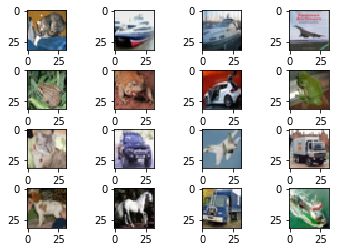

['cat', 'ship', 'automobile', 'airplane', 'frog', 'frog', 'automobile', 'frog', 'cat', 'automobile', 'airplane', 'truck', 'dog', 'horse', 'truck', 'ship']


In [42]:
#Show some predictions
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

show_Images(x_test[:16])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)
 
labels =  ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
 
indices = np.argmax(model.predict(x_test[:16]),1)
print ([labels[x] for x in indices])


3. Evaluate your module using the FERPlus dataset (The model with the best test accuracy will present their solution to the class).

    3.1 Download the [FER2013 dataset](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data) (images_path).
    
    3.2 Download the [FERPlus labels](https://github.com/Microsoft/FERPlus/blob/master/fer2013new.csv) (labels_path).
    
    3.3 Use the following code snippet to load the dataset giving the appropiate paths to the csv files downloaded in 3.1 and 3.2:

# Second dataset #

Now we use the very successful model implemented in the first part of the assignment to categorize emotions from the fer2013 dataset.

In [18]:
import pandas as pd
import numpy as np
import cv2

In [19]:
class FERPlus(object):
    """Class for loading FER2013 [1] emotion classification dataset with
    the FERPlus labels [2]:
    [1] kaggle.com/c/challenges-in-representation-learning-facial-\
            expression-recognition-challenge
    [2] github.com/Microsoft/FERPlu://github.com/Microsoft/FERPlus"""

    def __init__(self, images_path, labels_path, split='train', image_size=(48, 48),
                 dataset_name='FERPlus'):

        self.split = split
        self.image_size = image_size
        self.dataset_name = dataset_name
        self.images_path = images_path
        self.labels_path = labels_path
        self.class_names = ['neutral', 'happiness', 'surprise', 'sadness',
                            'anger', 'disgust', 'fear', 'contempt']
        self.num_classes = len(self.class_names)
        self.arg_to_name = dict(zip(range(self.num_classes), self.class_names))
        self.name_to_arg = dict(zip(self.class_names, range(self.num_classes)))
        self._split_to_filter = {
            'train': 'Training', 'val': 'PublicTest', 'test': 'PrivateTest'}

    def load_data(self):
        filter_name = self._split_to_filter[self.split]
        pixel_sequences = pd.read_csv(self.images_path)
        pixel_sequences = pixel_sequences[pixel_sequences.Usage == filter_name]
        pixel_sequences = pixel_sequences['pixels'].tolist()
        faces = []
        for pixel_sequence in pixel_sequences:
            face = [float(pixel) for pixel in pixel_sequence.split(' ')]
            face = np.asarray(face).reshape(48, 48)
            faces.append(cv2.resize(face, self.image_size))
        faces = np.asarray(faces)
        faces = np.expand_dims(faces, -1)

        emotions = pd.read_csv(self.labels_path)
        emotions = emotions[emotions.Usage == filter_name]
        emotions = emotions.iloc[:, 2:10].values
        N = np.sum(emotions, axis=1)
        mask = N != 0
        N, faces, emotions = N[mask], faces[mask], emotions[mask]
        emotions = emotions / np.expand_dims(N, 1)
        return faces, emotions

In [20]:
validation_data = FERPlus('Data\\fer2013\\fer2013.csv', 'Data\\fer2013new.csv')
faces, emotions = validation_data.load_data()

In [21]:
print(np.shape(faces))
print(np.shape(emotions))

split = 0.9

index = int(np.shape(faces)[0] * split)

faces_train = faces[:index]
emotions_train = emotions[:index]
faces_eval = faces[index:]
emotions_eval= emotions[index:]

(28559, 48, 48, 1)
(28559, 8)


In [25]:
from tensorflow.keras.callbacks import EarlyStopping
#Hyperparameters
#The data consists of 48x48 pixel grayscale images of faces.
img_shape = faces_train[0].shape
#The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
classes_number = 8

callbacks = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=4,
                              verbose=0, mode='auto')]

In [26]:
#MODEL: Simpler CNN; cite: https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import regularizers
 
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=img_shape))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(classes_number, activation='softmax'))

In [28]:


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(faces_train, emotions_train, batch_size=64,epochs=3, verbose=1,\
          validation_data=(faces_eval,emotions_eval), callbacks=callbacks)

model.evaluate(faces_eval, emotions_eval)

Train on 25703 samples, validate on 2856 samples
Epoch 1/3
25703/25703 [==============================] - 1254s 49ms/step - loss: 1.8867 - acc: 0.4943 - val_loss: 1.5179 - val_acc: 0.5788
Epoch 2/3
25703/25703 [==============================] - 1179s 46ms/step - loss: 1.5357 - acc: 0.6209 - val_loss: 1.4819 - val_acc: 0.5837
Epoch 3/3
2856/2856 [==============================] - 21s 7ms/step


[3.924549424681677, 0.33123249299719887]

# Archive

Here we tried to apply different modifications to the original AlexNet NN. After running this NN on the dataset for a single epoche, results were not promising and we stopped training.

In [8]:
#MODEL: AlexNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

# About CIFAR10:
# The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, 
# with 6000 images per class. There are 50000 training images and 10000 test images. 

#Hyperparameters
img_shape = (32,32,3)
classes_number = 10

ownnet = Sequential()

# Layer 1
# 16 pixels to one: 32 -> 8
# How many input neurons -> Lecture showed that less parameters and more layers are more useful
ownnet.add(Conv2D(classes_number * 3, (8, 8), input_shape=img_shape, padding='same'))
ownnet.add(BatchNormalization())
ownnet.add(Activation('relu'))
ownnet.add(MaxPooling2D(pool_size=(2, 2)))

# Another layer with double amount of filters
ownnet.add(Conv2D(classes_number * 6, (8, 8), input_shape=img_shape, padding='same'))
ownnet.add(BatchNormalization())
ownnet.add(Activation('relu'))
ownnet.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2
ownnet.add(Conv2D(128, (4, 4), padding='same'))
ownnet.add(BatchNormalization())
ownnet.add(Activation('relu'))
ownnet.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3
ownnet.add(Conv2D(128, (3, 3), padding='same'))
ownnet.add(BatchNormalization())
ownnet.add(Activation('relu'))
ownnet.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4
ownnet.add(Conv2D(128, (3, 3), padding='same'))
ownnet.add(BatchNormalization())
ownnet.add(Activation('relu'))

# Layer 5
ownnet.add(Conv2D(256, (3, 3), padding='same'))
ownnet.add(BatchNormalization())
ownnet.add(Activation('relu'))
ownnet.add(MaxPooling2D(pool_size=(2, 2)))

# Another layer
ownnet.add(Conv2D(64, (2, 2), padding='same'))
ownnet.add(BatchNormalization())
ownnet.add(Activation('relu'))

ownnet.add(Flatten())

# Layer 6 - fully connected layer
ownnet.add(Dense(1024))
ownnet.add(BatchNormalization())
ownnet.add(Activation('relu'))
ownnet.add(Dropout(0.5))

# Layer 7
ownnet.add(Dense(512))
ownnet.add(BatchNormalization())
ownnet.add(Activation('relu'))
ownnet.add(Dropout(0.5))

# Layer 8
ownnet.add(Dense(classes_number))
ownnet.add(BatchNormalization())
ownnet.add(Activation('softmax'))

ownnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 30)        5790      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 30)        120       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 30)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 30)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 60)        115260    
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 16, 60)        240       
_________________________________________________________________
activation_9 (Activation)    (None, 16, 16, 60)        0         
__________

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 287s 6ms/step - loss: 1.7042 - acc: 0.3946 - val_loss: 2.1963 - val_acc: 0.1489

In [9]:
#Compile 
ownnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Train
ownnet.fit(x_train, y_train_categorical, validation_data=(x_test,y_test_categorical), batch_size=1000, epochs=1, verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 287s 6ms/step - loss: 1.7042 - acc: 0.3946 - val_loss: 2.1963 - val_acc: 0.1489


Results of frist try were mixed, therefore some adjustments
Use Leaky RelU instead of normal ReLU to prevent dead ReLU
Add more filters to first layer, less to 2nd
Added another dense layer
Less pooling functions

In [81]:
#MODEL: AlexNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU

# About CIFAR10:
# The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, 
# with 6000 images per class. There are 50000 training images and 10000 test images. 

#Hyperparameters
img_shape = (32,32,3)
classes_number = 10

ownnet = Sequential()

# Use smaller kernel but combinded with strides
ownnet.add(Conv2D(classes_number * 10, (10, 10), input_shape=img_shape, padding='valid', strides=2))
ownnet.add(BatchNormalization())
ownnet.add(LeakyReLU(alpha=0.01))

# Another layer with double amount of filters
ownnet.add(Conv2D(classes_number * 8, (8, 8), input_shape=img_shape, padding='same'))
ownnet.add(BatchNormalization())
ownnet.add(LeakyReLU(alpha=0.01))
ownnet.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2
ownnet.add(Conv2D(256, (6, 6), padding='same'))
ownnet.add(BatchNormalization())
ownnet.add(LeakyReLU(alpha=0.01))
ownnet.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3
ownnet.add(Conv2D(128, (5, 5), padding='same'))
ownnet.add(BatchNormalization())
ownnet.add(LeakyReLU(alpha=0.01))
ownnet.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4
ownnet.add(Conv2D(128, (4, 4), padding='same'))
ownnet.add(BatchNormalization())
ownnet.add(LeakyReLU(alpha=0.01))

# Layer 5
ownnet.add(Conv2D(64, (3, 3), padding='same'))
ownnet.add(BatchNormalization())
ownnet.add(LeakyReLU(alpha=0.01))

# Another layer
ownnet.add(Conv2D(64, (2, 2), padding='same'))
ownnet.add(BatchNormalization())
ownnet.add(LeakyReLU(alpha=0.01))
ownnet.add(Flatten())

# Layer 6 - fully connected layer
ownnet.add(Dense(512))
ownnet.add(BatchNormalization())
ownnet.add(LeakyReLU(alpha=0.01))
ownnet.add(Dropout(0.5))

# Layer 7
ownnet.add(Dense(256))
ownnet.add(BatchNormalization())
ownnet.add(LeakyReLU(alpha=0.01))
ownnet.add(Dropout(0.5))

# Layer 7
ownnet.add(Dense(128))
ownnet.add(BatchNormalization())
ownnet.add(LeakyReLU(alpha=0.01))
ownnet.add(Dropout(0.5))

# Layer 8
ownnet.add(Dense(classes_number))
ownnet.add(BatchNormalization())
ownnet.add(Activation('softmax'))

ownnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_224 (Conv2D)          (None, 12, 12, 100)       30100     
_________________________________________________________________
batch_normalization_301 (Bat (None, 12, 12, 100)       400       
_________________________________________________________________
leaky_re_lu_231 (LeakyReLU)  (None, 12, 12, 100)       0         
_________________________________________________________________
conv2d_225 (Conv2D)          (None, 12, 12, 80)        512080    
_________________________________________________________________
batch_normalization_302 (Bat (None, 12, 12, 80)        320       
_________________________________________________________________
leaky_re_lu_232 (LeakyReLU)  (None, 12, 12, 80)        0         
_________________________________________________________________
max_pooling2d_163 (MaxPoolin (None, 6, 6, 80)          0         
__________

In [ ]:
#Compile 
ownnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Train
ownnet.fit(x_train, y_train_categorical, validation_data=(x_test,y_test_categorical), batch_size=1000, epochs=1, verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
 5000/50000 [==>...........................] - ETA: 7:47 - loss: 2.6747 - acc: 0.1000

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 461s 9ms/step - loss: 2.1342 - acc: 0.2192 - val_loss: 2.3551 - val_acc: 0.1136

2nd try results were worse: Changeing first layer: No strides and smaller kernles (to enable edge detection)
Using elu function instead of relu at two random points
Reduced amount of parameters extremly (especially less filters in first few layers)
Added another filter layer at start and another dense layer at end, therefore reduced density.

In [4]:
#MODEL: AlexNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU

# About CIFAR10:
# The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, 
# with 6000 images per class. There are 50000 training images and 10000 test images. 

#Hyperparameters
img_shape = (32,32,3)
classes_number = 10

ownnet = Sequential()

# Use smaller kernel to improve potential edge detection 
ownnet.add(Conv2D(classes_number * 10, (3, 3), input_shape=img_shape, padding='same'))
ownnet.add(BatchNormalization())
ownnet.add(LeakyReLU(alpha=0.01))

# Another layer with double amount of filters
ownnet.add(Conv2D(classes_number * 8, (5, 5), input_shape=img_shape, padding='same'))
ownnet.add(BatchNormalization())
ownnet.add(LeakyReLU(alpha=0.01))
ownnet.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2
ownnet.add(Conv2D(128, (6, 6), padding='same'))
ownnet.add(BatchNormalization())
ownnet.add(Activation('elu'))
ownnet.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3
ownnet.add(Conv2D(96, (5, 5), padding='same'))
ownnet.add(BatchNormalization())
ownnet.add(LeakyReLU(alpha=0.01))
ownnet.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4
ownnet.add(Conv2D(64, (4, 4), padding='same'))
ownnet.add(BatchNormalization())
ownnet.add(LeakyReLU(alpha=0.01))

# Layer 5
ownnet.add(Conv2D(58, (3, 3), padding='same'))
ownnet.add(BatchNormalization())
ownnet.add(Activation('elu'))

# Another layer
ownnet.add(Conv2D(42, (2, 2), padding='same'))
ownnet.add(BatchNormalization())
ownnet.add(LeakyReLU(alpha=0.01))
ownnet.add(Flatten())

# Layer 6 - fully connected layer
ownnet.add(Dense(256))
ownnet.add(BatchNormalization())
ownnet.add(LeakyReLU(alpha=0.01))
ownnet.add(Dropout(0.5))

# Layer 7
ownnet.add(Dense(128))
ownnet.add(BatchNormalization())
ownnet.add(Activation('elu'))
ownnet.add(Dropout(0.5))

# Layer 7
ownnet.add(Dense(64))
ownnet.add(BatchNormalization())
ownnet.add(LeakyReLU(alpha=0.01))
ownnet.add(Dropout(0.5))

# Layer 7
ownnet.add(Dense(32))
ownnet.add(BatchNormalization())
ownnet.add(LeakyReLU(alpha=0.01))
ownnet.add(Dropout(0.5))


# Layer 8
ownnet.add(Dense(classes_number))
ownnet.add(BatchNormalization())
ownnet.add(Activation('softmax'))

ownnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 100)       2800      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 100)       400       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 100)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 80)        200080    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 80)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 80)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 80)        0         
__________

In [5]:
#Compile 
ownnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Train
ownnet.fit(x_train, y_train_categorical, validation_data=(x_test,y_test_categorical), batch_size=1000, epochs=1, verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 26171s 523ms/step - loss: 2.2899 - acc: 0.1791 - val_loss: 12.4215 - val_acc: 0.1001


Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 26171s 523ms/step - loss: 2.2899 - acc: 0.1791 - val_loss: 12.4215 - val_acc: 0.1001